## Imports:

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from random import randint

# -----------------------------------------------------------------------------------------------------------------

## Environment Parameters:

In [3]:
#Time-step
del_t = 0.01

#Friction coefficient between slider and surface:
mu1 = 0.3

#Friction coefficient between gripper and slider:
mu2 = 0.1

#Block dimensions:
length = 0.3
breadth = 0.1
height = 0.1

#Mass of block in kg:
mass = 0.2

#Moment of Inertia (Cuboid here):
Iz = (mass * (length**2 + breadth**2)) / 12

#Friction:
Fr = mu1 * mass * 9.81

#Start Point (x, y, theta):
start = np.array([0.3, 0.3, 0.0])

# -----------------------------------------------------------------------------------------------------------------

## Helper Functions: 

In [4]:
def unpack_params(i, ext_force, contact_points, pos, vel):
    
    fcx, fcy = ext_force[i, :2]
    phi = contact_points[i, 0]

    theta = pos[i, 2]
    Rbs = np.array([[np.cos(theta), np.sin(theta)],
                    [- np.sin(theta), np.cos(theta)]])
    
    curr_vel = vel[i, :]
    
    return fcx, fcy, phi, Rbs, curr_vel

In [117]:
def unit_vector(v_input):
    
    v = v_input.copy()
    for i in range(v.size):
        if np.abs(v[i]) != 0.0:
            v[i] = v[i]/np.linalg.norm(v)
        else:
            v[i] = 0.0
    return v

In [6]:
def direction(v):
    
    if np.abs(v) != 0.0:
        return v / np.abs(v)
    else:
        return 0.0

In [120]:
a = [4, 5]
b = a[:]
b[1] = 1
a, b

([4, 5], [4, 1])

# -----------------------------------------------------------------------------------------------------------------

## Define Geometry of slider block w.r.t angle phi

#### Geometry function r(phi):

In [7]:
def slider_geometry(phi, l, b):
    
    # phi belongs to [-pi, pi]
    
    if phi > np.pi:
        phi = phi - 2*np.pi
    elif phi < -np.pi:
        phi = 2*np.pi + phi
    
    interval1 = - np.arctan(b/l) - 2*np.arctan(l/b)
    interval2 = - np.arctan(b/l)
    interval3 = np.arctan(b/l)
    interval4 = np.arctan(b/l) + 2*np.arctan(l/b)
    
    if (phi > interval1 and phi < interval2) or (phi > interval3 and phi < interval4):
        r = b/(2*np.sin(phi))
        
    else:
        r = l/(2*np.cos(phi))
        
    return np.abs(r)

In [8]:
def get_contact_frame(phi, l, b):
    
    r = slider_geometry(phi, l, b)
    contact = np.array([r*np.cos(phi), r*np.sin(phi)])
    contact_unit = unit_vector(contact)
    
    r_front = slider_geometry(phi + 0.001, l, b)
    contact_front = np.array([r_front*np.cos(phi + 0.001), r_front*np.sin(phi + 0.001)])
    
    r_back = slider_geometry(phi - 0.001, l, b)
    contact_back = np.array([r_back*np.cos(phi - 0.001), r_back*np.sin(phi - 0.001)])
    
    front_dir = unit_vector(contact_front - contact)
    back_dir = unit_vector(contact_back - contact)
    
    front_angle = np.arctan2(front_dir[1], front_dir[0])
    back_angle = np.arctan2(back_dir[1], back_dir[0])
    
    angle_bisect = (back_angle - front_angle) / 2
    angle_bisect = angle_bisect + (1 - direction(angle_bisect)) * np.pi / 2
    
    normal_angle = front_angle + angle_bisect
    tangent_angle = normal_angle - np.pi/2
    
    normal = np.array([np.cos(normal_angle), np.sin(normal_angle)])
    tangent = np.array([np.cos(tangent_angle), np.sin(tangent_angle)])
    
    return normal, tangent
    

#### Force transformation from contact point to linear force + torque on C.O.M:

In [177]:
def transform_forces(fcx, fcy, phi, Rbs, vel, Fr, mu2, l, b):
    
    r = slider_geometry(phi, l, b)
    contact = np.round(np.array([r*np.cos(phi), r*np.sin(phi)]), 12)
    contact_unit = unit_vector(contact)
    
    force = (Rbs @ (np.array([[fcx, fcy]]).T)).T[0]
    force_unit = unit_vector(force)

    contact_angle = np.arctan2(force_unit[1], force_unit[0]) - np.arctan2(contact_unit[1], contact_unit[0])
    inverse_phi = np.arctan2(-contact_unit[1], -contact_unit[0])
    
    Fcom = np.dot(force, -contact_unit)
    
    Fbx = Fcom * np.cos(inverse_phi)
    Fby = Fcom * np.sin(inverse_phi)
    
    F_translational = np.round((Rbs.T @ (np.array([[Fbx, Fby]]).T)).T[0], 12)
    torque_force = np.round(np.linalg.norm(force) * np.sin(contact_angle), 12)
    
    vel_b = (Rbs @ (np.array([vel[:2]]).T)).T[0]
    inverse_vel_angle = np.arctan2(-vel_b[1], -vel_b[0])
    
    if np.linalg.norm(vel[:2]) != 0:
        Frx = Fr * np.cos(inverse_vel_angle)
        Fry = Fr * np.sin(inverse_vel_angle)
    elif abs(Fcom) > Fr:
        Frx = Fr * np.cos(phi)
        Fry = Fr * np.sin(phi)
    else:
        Frx = 0.0
        Fry = 0.0
    
    F_friction = np.round((Rbs.T @ (np.array([[Frx, Fry]]).T)).T[0], 12)
    
    if np.linalg.norm(vel[2]) != 0:
        torque_friction = -1 * Fr * direction(vel[2])
    elif abs(torque_force) > Fr:
        torque_friction = -1 * Fr * direction(torque_force)
    else:
        torque_friction = 0.0
    
    print(torque_friction)
    
    F = np.append(F_translational, torque_force)
    Friction = np.append(F_friction, torque_friction)
    
    #Check if force is non-sliding:
    
    normal, tangent = get_contact_frame(phi, l, b)

    Fn = np.dot(normal, force)
    Ft = np.dot(tangent, force)

    if Fn < 0:
        raise Exception("Force is not directed towards the block")
    if np.abs(Ft) > mu2 * np.abs(Fn):
        raise Exception("Force applied will cause sliding against block surface, therefore it is invalid")
    
    #Accounting for Friction:
    
    #print(Friction)
    
#     for i in range(F.size):
        
#         if (vel[i] != 0):
#             F[i] += Friction[i] #* direction(vel[i])
#         elif (vel[i] == 0 and abs(F[i]) > abs(Friction[i])):
#             F[i] += Friction[i] #* direction(F[i])
#         else:
#             F[i] = 0.0
        
    F = F[:] + Friction[:]
    F[2] *= r
    
    return F

##### Testing force transformation:

In [105]:
theta = 0.0 #30 * np.pi / 180
Rbs = np.array([[np.cos(theta), np.sin(theta)],
                [- np.sin(theta), np.cos(theta)]])

test_vel = np.array([0.0, 0.0, 0.0])

fcx = 0.0
fcy = 40.0
phi = -45 * np.pi / 180

transform_forces(fcx, fcy, phi, Rbs, test_vel, Fr, mu2, length, breadth)

Force, Contact =  [0. 1.] [ 0.70710678 -0.07053456]


Exception: Force applied will cause sliding against block surface, therefore it is invalid

# -----------------------------------------------------------------------------------------------------------------

## Physics:

#### System State:
1) position -> (x, y, theta)
2) velocities -> (vx, vy, omega)
3) accelerations -> (ax, ay, alpha)
4) Tbs -> Transformation from space frame to base frame
5) Rbs -> Rotation from space frame to base frame

In [178]:
#Total simulation time in seconds:
T = 5

#Total number of trajectory points:
N = int(T/del_t + 1)

pos = np.zeros((N, 3))
vel = np.zeros((N, 3))
acc = np.zeros((N, 3))

pos[0, :] = start.copy()

#### External Parameters:
1) force_x
2) force_y
3) contact_points

In [179]:
ext_force = np.zeros((N, 2))
#contact_points = np.zeros((N, 1))
contact_points = np.ones((N, 1)) * (45 * np.pi/180)

#Initial force:
ext_force[0, 0] = 0.0
ext_force[0, 1] = -20.0

# -----------------------------------------------------------------------------------------------------------------

## Generate Simulation Data:

In [180]:
fcx, fcy, phi, Rbs, curr_vel = unpack_params(0, ext_force, contact_points, pos, vel)
F = transform_forces(fcx, fcy, phi, Rbs, curr_vel, Fr, mu2, length, breadth)

acc[0, :2] = F[:2] / mass
acc[0, 2] = F[2] / Iz

prev_fcx = 1.0
prev_fcy = 1.0

for i in range(1, N):
    
    vel[i, :] = vel[i-1, :] + del_t * acc[i-1, :]
    pos[i, :] = pos[i-1, :] + del_t * vel[i-1, :]
    
    print("---------------------------------")
    print("Iteration = ", i)
    
    for j in range(3):
        
        if np.linalg.norm(prev_fcx) == 0 and np.linalg.norm(prev_fcy) == 0 and direction(vel[i, j]) == -direction(vel[i-1, j]):
#             print(prev_fcx, prev_fcy, direction(vel[i, j]), direction(vel[i-1, j]))
#             print("Setting ", j, " velocity to zero")
            vel[i, j] = 0.0
    
    fcx, fcy, phi, Rbs, curr_vel = unpack_params(i, ext_force, contact_points, pos, vel)
    #print("Velocity = ", vel[i])
    F = transform_forces(fcx, fcy, phi, Rbs, curr_vel, Fr, mu2, length, breadth)
    #print("Force = ", F)
    
    acc[i, :2] = F[:2] / mass
    acc[i, 2] = F[2] / Iz
        
    prev_fcx = fcx
    prev_fcy = fcy
    

0.5886
---------------------------------
Iteration =  1
0.5886
---------------------------------
Iteration =  2
0.5886
---------------------------------
Iteration =  3
0.5886
---------------------------------
Iteration =  4
0.5886
---------------------------------
Iteration =  5
0.5886
---------------------------------
Iteration =  6
0.5886
---------------------------------
Iteration =  7
0.5886
---------------------------------
Iteration =  8
0.5886
---------------------------------
Iteration =  9
0.5886
---------------------------------
Iteration =  10
0.5886
---------------------------------
Iteration =  11
0.5886
---------------------------------
Iteration =  12
0.5886
---------------------------------
Iteration =  13
0.5886
---------------------------------
Iteration =  14
0.5886
---------------------------------
Iteration =  15
0.5886
---------------------------------
Iteration =  16
0.5886
---------------------------------
Iteration =  17
0.5886
---------------------------------

## Visualize Simulation:

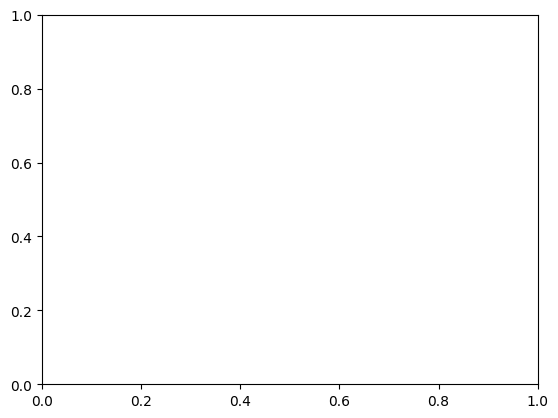

In [64]:
# create empty lists for the x and y data
x = []
y = []

# create the figure and axes objects
fig, ax = plt.subplots()

def animate(i):
    pt = randint(1,9) # grab a random integer to be the next y-value in the animation
    x.append(i)
    y.append(pt)

    ax.clear()
    ax.plot(x, y)
    ax.set_xlim([0,20])
    ax.set_ylim([0,10])
    
# run the animation
ani = FuncAnimation(fig, animate, frames=20, interval=500, repeat=False)

plt.show()

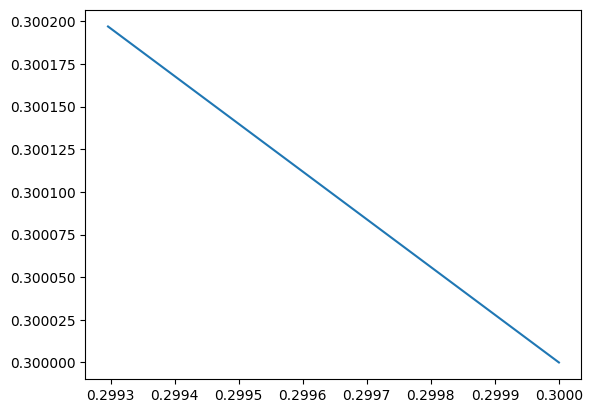

In [172]:
plt.plot(pos[:, 0], pos[:, 1])

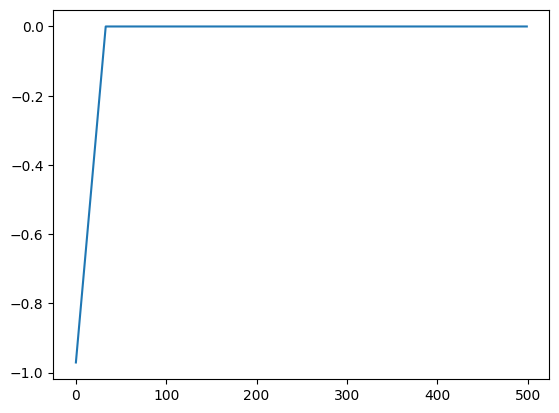

In [166]:
plt.plot(vel[1:, 1])

In [167]:
vel[:, 1] 

array([ 0.     , -0.97057, -0.94114, -0.91171, -0.88228, -0.85285,
       -0.82342, -0.79399, -0.76456, -0.73513, -0.7057 , -0.67627,
       -0.64684, -0.61741, -0.58798, -0.55855, -0.52912, -0.49969,
       -0.47026, -0.44083, -0.4114 , -0.38197, -0.35254, -0.32311,
       -0.29368, -0.26425, -0.23482, -0.20539, -0.17596, -0.14653,
       -0.1171 , -0.08767, -0.05824, -0.02881,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.  

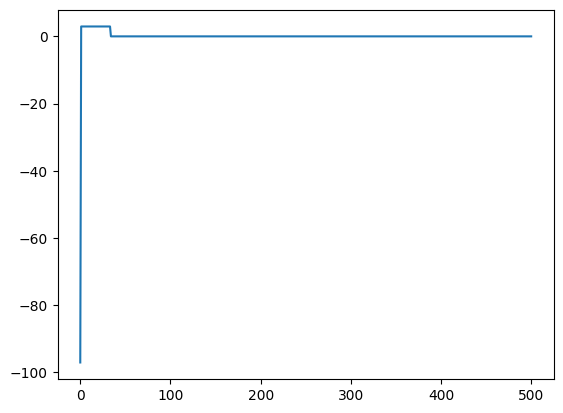

In [168]:
plt.plot(acc[:, 1])

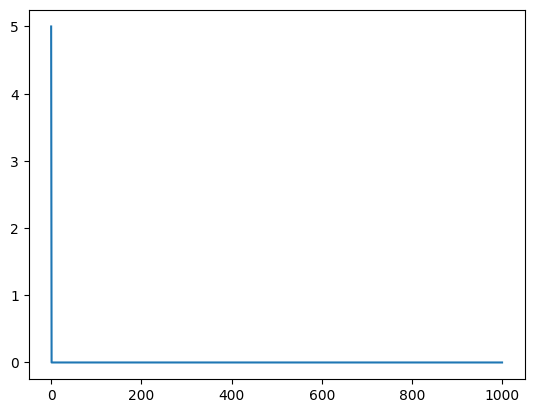

In [181]:
plt.plot(ext_force[:, 0])

In [212]:
acc[:, 2]

array([17.658, -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
      

In [ ]:
## Introduce a RTF calculation and display system using the time library
